In [11]:
import numpy as np
from scipy.integrate import *
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

import numpy as np
from scipy.stats import ortho_group

1. Implement a function simulate_sir_simple(lam, mu, I_0, T), that takes the specified parameters
and simulates the epidemy using the Euler forward scheme up to day T. The vector of hidden
parameters is therefore Y = [λ, µ, I0]. The function shall return the sequence of observations
X = [...]
For debugging and visualization, it is also useful to return the sequence of corresponding ODE
variables
C = [...]

In [12]:
def sir_odes(initial_values, infection_rate, recovery_rate, population):
    s_t, i_t, _ = initial_values
    
    dS = -infection_rate * (s_t * i_t)/population
    dR = recovery_rate * i_t
    dI = -dS - dR
    
    return np.array([dS, dI, dR])

    

In [13]:
def forward_euler(f, iv, delta_t, number_of_steps):
    solution = [np.array(iv)]
    time = np.array([delta_t * i for i in range(number_of_steps)])
    for i in range(len(time)):
        t = time[i]
        solution.append(solution[i] + delta_t * f(solution[i]))
    
    return np.array(solution)
    
    
    

In [14]:
def generate_deltas(results, L = 0, rho=1, sigma_2=0):
    assert L >= 0
    assert rho <= 1
    s = results[:, 0]
    r = results[:, 2]
    deltas =np.array([(s[(t-L)-1] - s[(t-L)], r[(t-L)] - r[(t-L) - 1]) for t in range(L + 1, len(s))])
    noise = np.random.normal(rho, sigma_2, deltas.shape)
    deltas *= noise
    if L > 0:
        deltas = np.vstack(([[0, 0] for i in range(L)],  deltas))
    return deltas

In [15]:
def simulate_sir_simple(lam, mu, I_0, T):
    assert I_0 >= 0 and I_0 <= 1
    ivs = [1 - I_0, I_0, 0]
    odes = lambda ivs: sir_odes(ivs, lam, mu, 1)
    
    return forward_euler(odes, ivs, 1, T)
    

In [16]:
def plot_simulation(lam, mu, I_0, T):
    results = simulate_sir_simple(lam, mu, I_0, T)
    deltas = generate_deltas(results)
    s = results[:, 0]
    i = results[:, 1]
    r = results[:, 2]
    time_range = [t for t in range(T + 1)]
    fig1 = plt.figure()
    plt.scatter(time_range, s, label="Susceptible", marker=".", s = 3, color="y")
    plt.scatter(time_range, i, label="Infected", marker="x", s = 3, color="r")
    plt.scatter(time_range, r, label="Recovered", marker=",", s= 3, color="g")
    plt.scatter(time_range, s + i + r, label="population", marker ="_", s = 3, color="k")
    plt.title(f"Simulation with parameters $\lambda$: {lam}, $\mu$: {mu}, $I_0$: {I_0}", usetex = True)
    plt.ylabel("Normalized population")
    plt.xlabel("Time")
    plt.legend()
    fig2 = plt.figure()
    plt.title(f"Deltas of compartments S and R with parameters $\lambda$: {lam}, $\mu$: {mu}, $I_0$: {I_0}", usetex = True)
    plt.scatter(time_range[:-1], deltas[:, 0], marker="v", s=3, color="y", label="deltaS")
    plt.scatter(time_range[:-1], deltas[:, 1], marker="^", s=3, color="g", label="deltaR")
    plt.ylabel("Change in population")
    plt.xlabel("Time")
    plt.legend()
    return fig1, fig2

In [17]:
def plot_many_random_simulations(n=5, T=100, lam_range = (0.01, 1), mu_range = (0.01, 1), I_0_range = (0.01, 1)):
    fig, axs = plt.subplots(n, 3, figsize=(15, 15))
    i = 0
    fig.suptitle(f"{n}x3 random simulations" , usetex = True)
    for ax in axs.flatten():
        lam = round(np.random.uniform(*lam_range), 2)
        mu = round(np.random.uniform(*mu_range), 2)
        I_0 = round(np.random.uniform(*I_0_range), 2)
        results = simulate_sir_simple(lam, mu, I_0, T)
        s = results[:, 0]
        i = results[:, 1]
        r = results[:, 2]
        time_range = [t for t in range(T + 1)]
        ax.scatter(time_range, s, label="Susceptible", marker=".", s = 3, color="y")
        ax.scatter(time_range, i, label="Infected", marker="x", s = 3, color="r")
        ax.scatter(time_range, r, label="Recovered", marker=",", s= 3, color="g")
        ax.scatter(time_range, s + i + r, label="population", marker ="_", s = 3, color="k")
        ax.set_ylabel(f"$\lambda$: {lam}, $\mu$: {mu}, $I_0$: {I_0}", usetex = True)
        handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels)
    fig.text(0.5, 0.04, 'Time', ha='center')
    fig.text(0.04, 0.5, 'Normalized population', va='center', rotation='vertical')

2. Run the simulation with T = 100 and visualize the results. Determine suitable ranges of
the parameters such that the 
rst 100 days exhibit interesting and diverse dynamics. This is
important, because when not much happens between day 1 and day T, there will be insu
cient
information to solve the inverse problem. Use the results of these experiments to de
ne the
simulation prior
p
sim(Y ) = p
sim(λ) · p
sim(µ) · p
sim(I0)

Below can be observed that for large $\mu$, the behaviour is not interesting, the infection dies down long befor t=100.
$\mu$ should be less then 0.15.

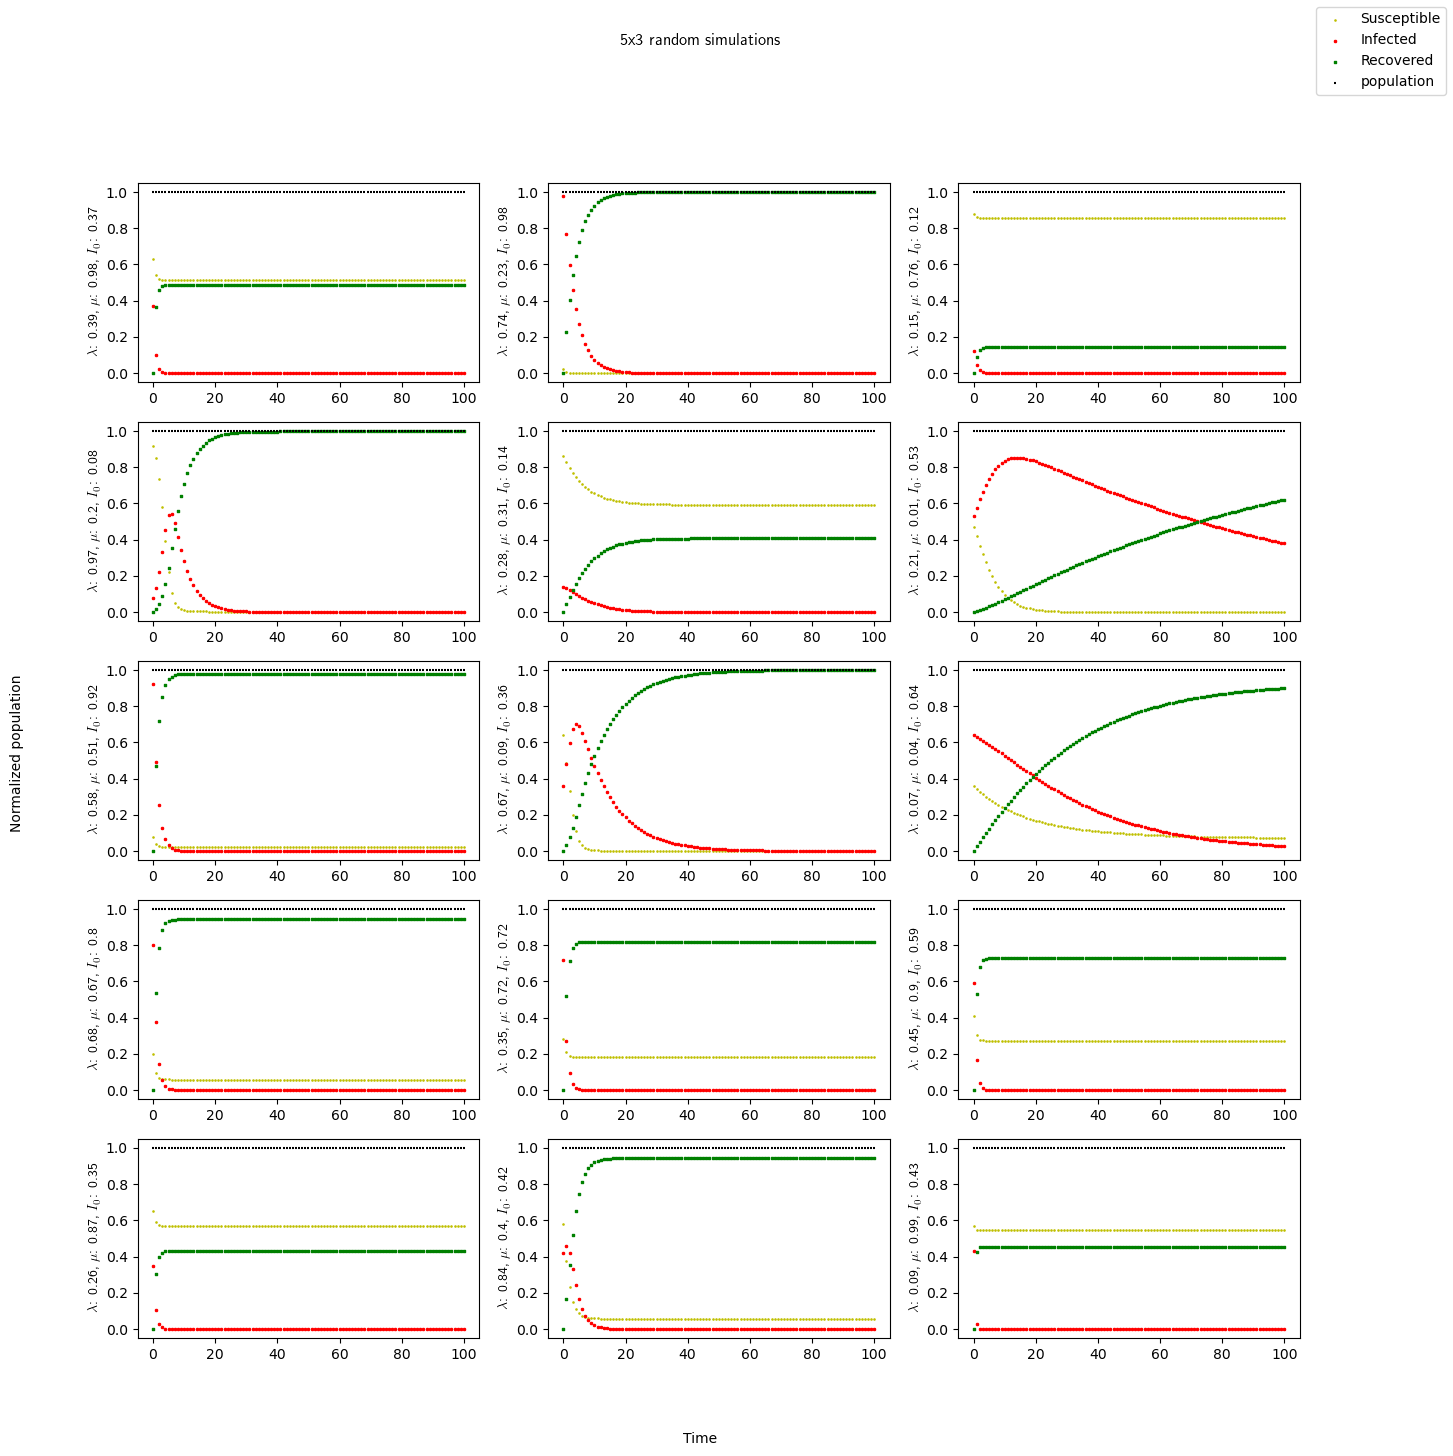

In [18]:
plot_many_random_simulations(n = 5)

With this modification, the dynamics below become more interesting. However for large $\lambda$, the simulation becomes stationary well before t=100. Hence the $\lambda$ should be reduced to a maximum of 0.25.

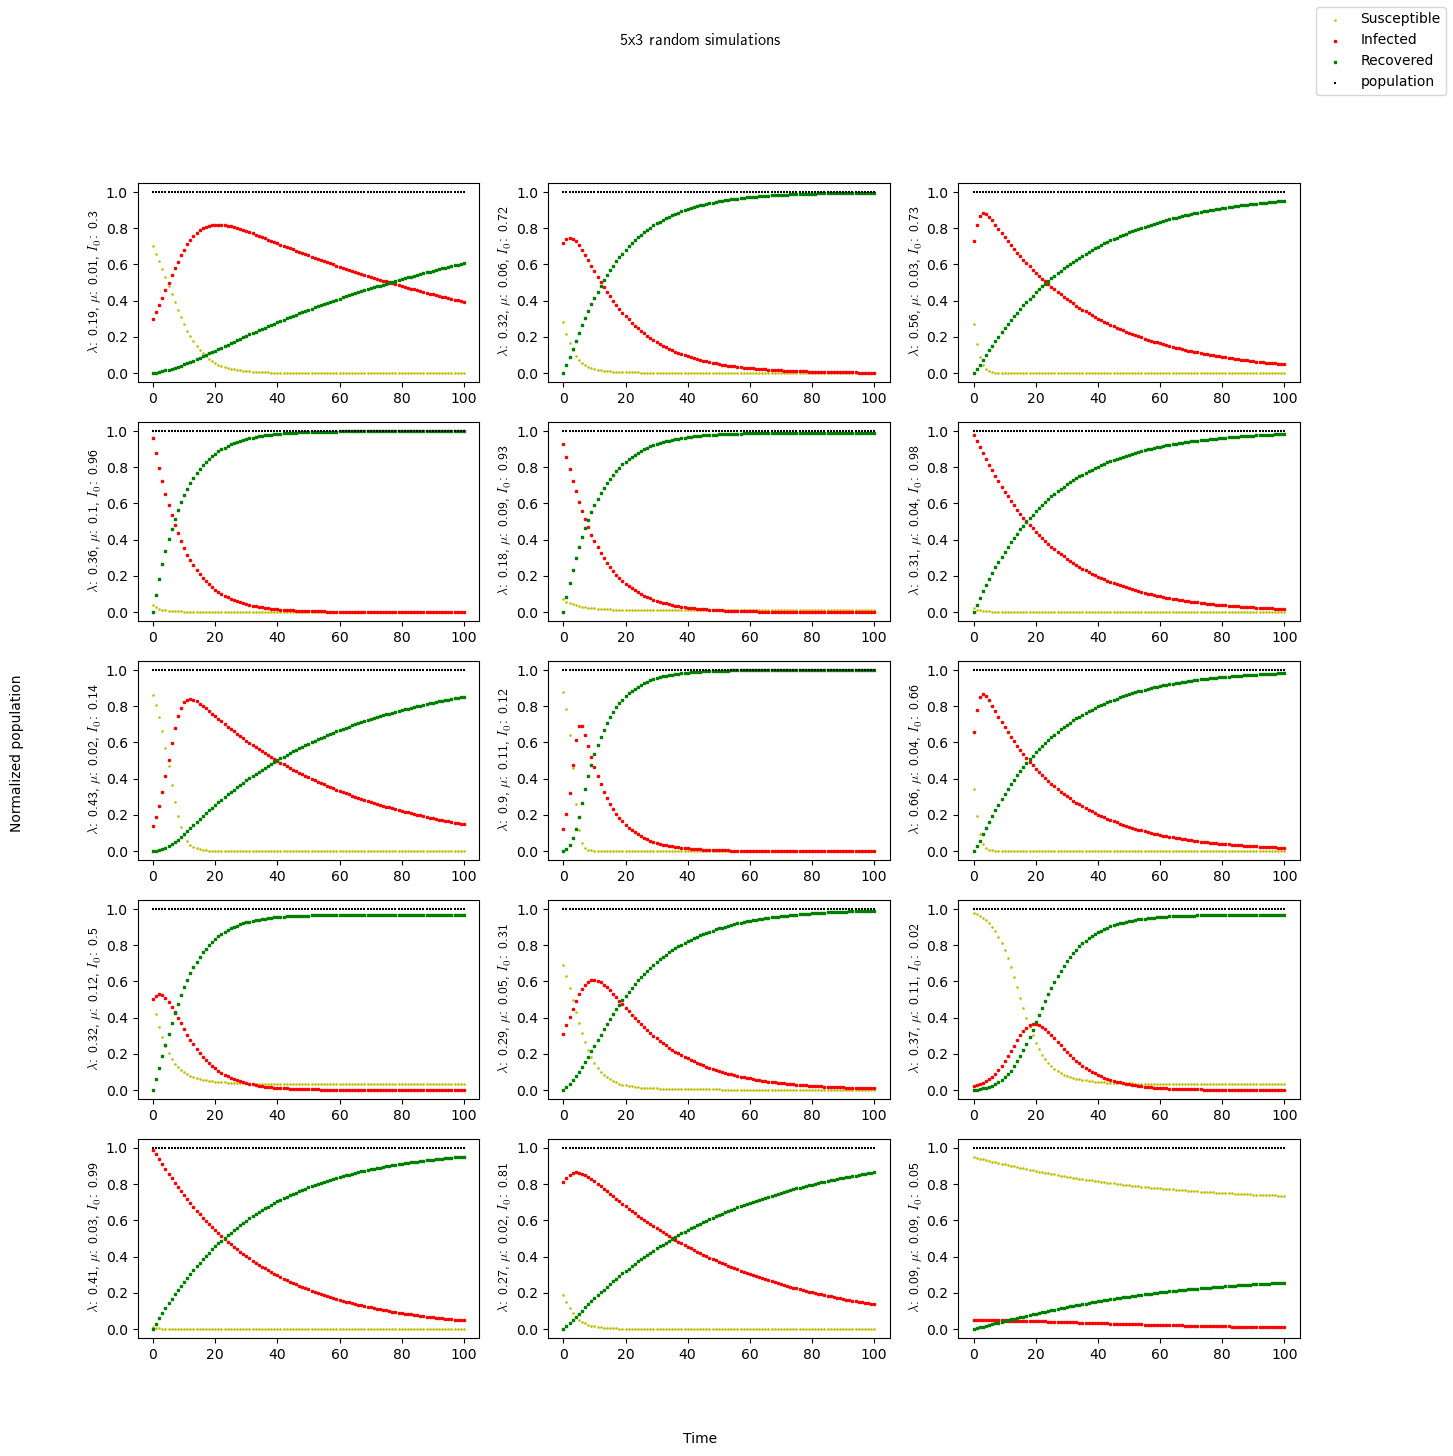

In [19]:
plot_many_random_simulations(n = 5, mu_range=(0.01, 0.15))

The simulations below that have the most change in all compartements over the entire time range are those with small $I_0$. A good choice could be $I_0 \leq 0.15$. 

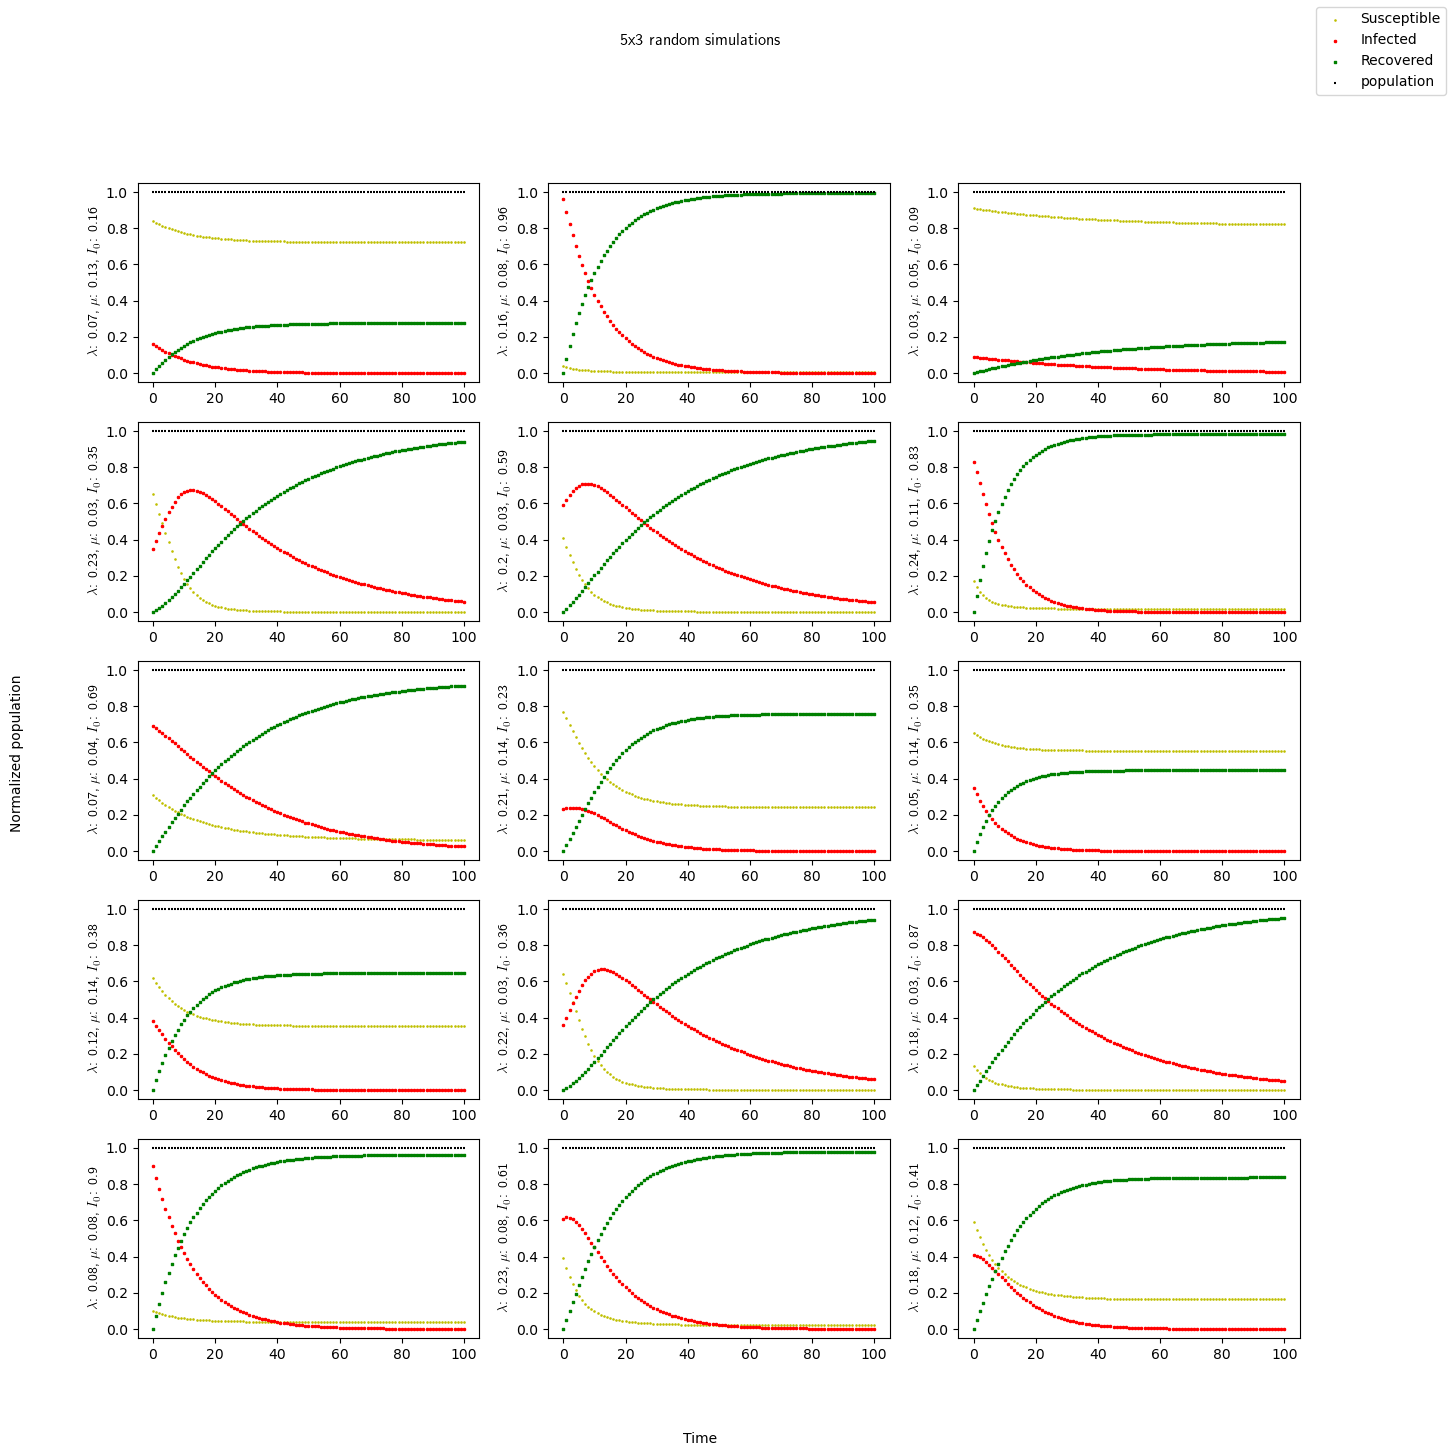

In [20]:
plot_many_random_simulations(n = 5, mu_range=(0.01, 0.15), lam_range=(0.01, 0.25))

The results below look better than the initial ones, however it seems that for too small $\lambda$ the infection spreads too slowly. Hence the minimal $\lambda$ is set to 0.1.

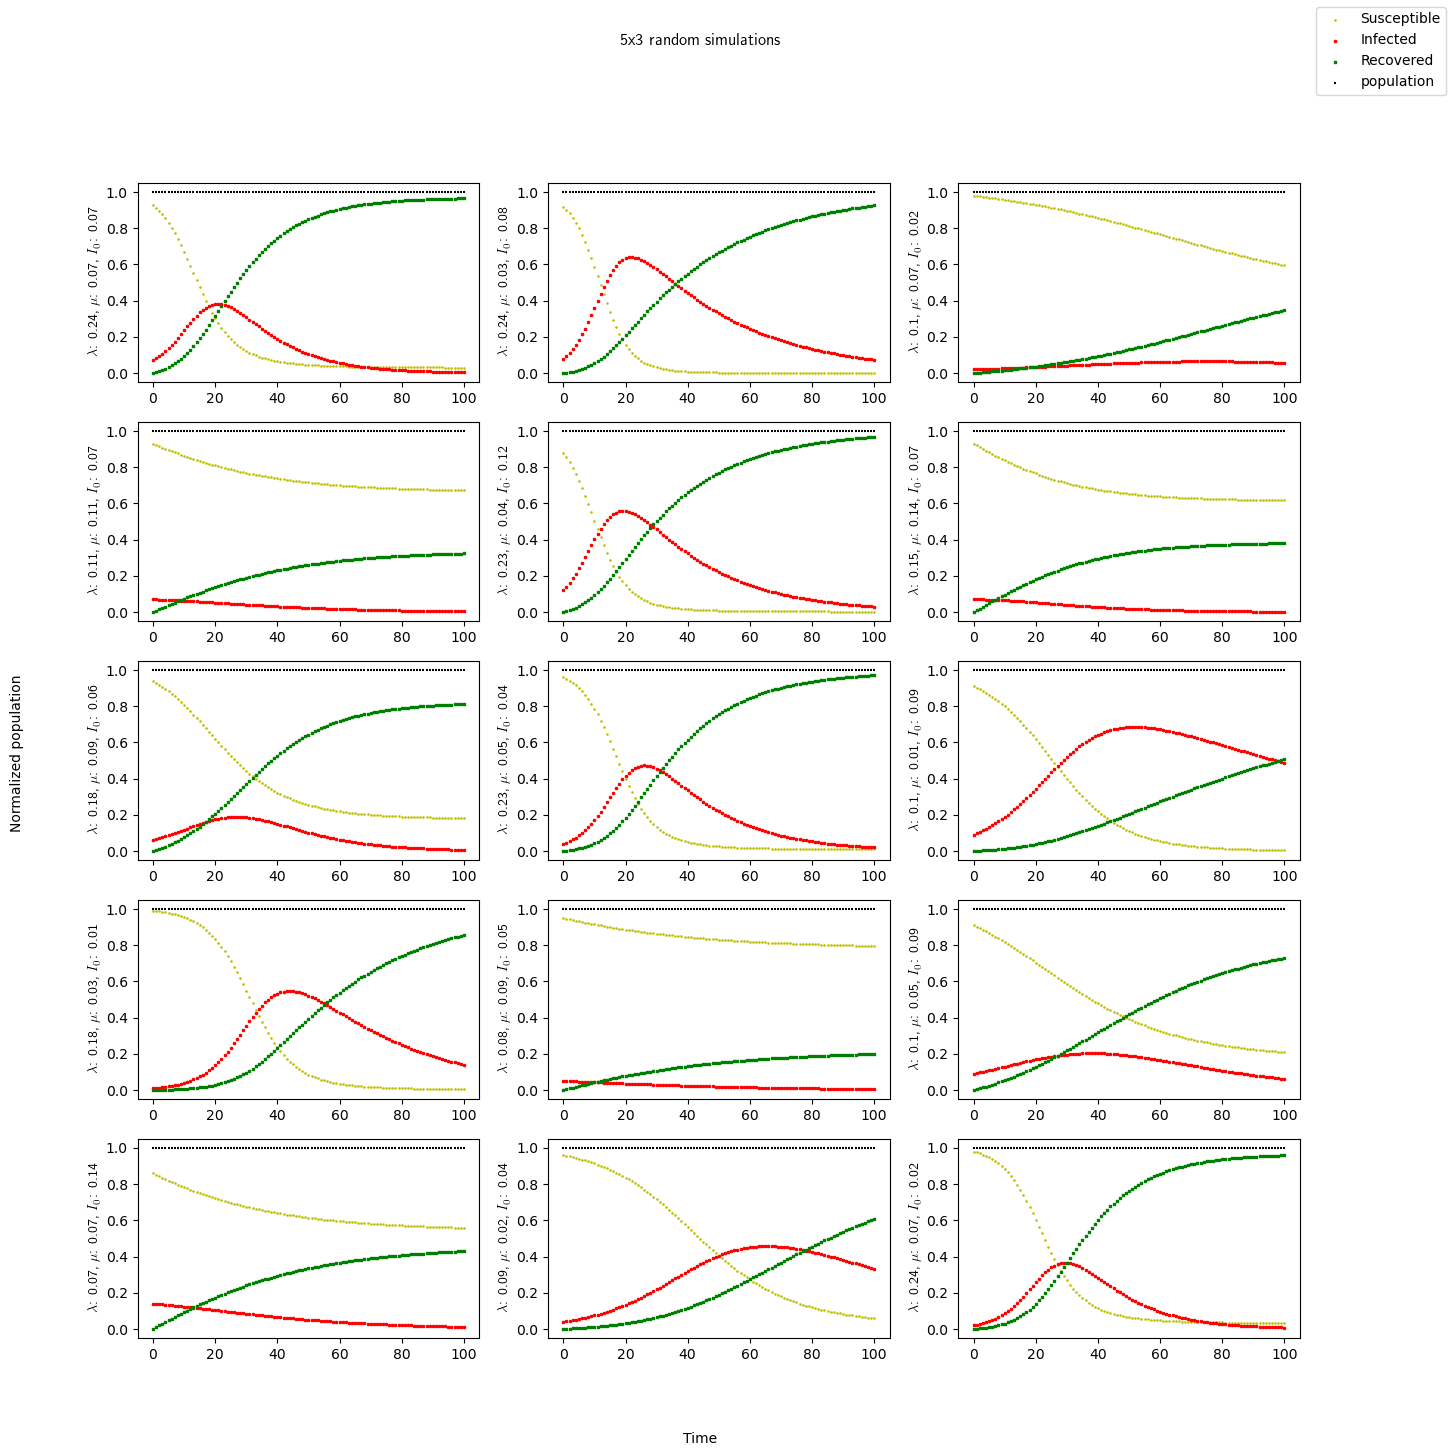

In [21]:
plot_many_random_simulations(n = 5, I_0_range =(0.01, 0.15), mu_range=(0.01, 0.15), lam_range=(0.01, 0.25))

In the plots below, it can be observed that for small $I_0$, it takes too long for the infection to spread if the infection rate is too close to the recovery rate. Hence the minimal $I_0$ is set to 0.05. This is some measure to ensure that at least most of simulations are suitable for training, since $I_0$ can be quite small if the difference between the recovery rate and the infection rate is quite large.

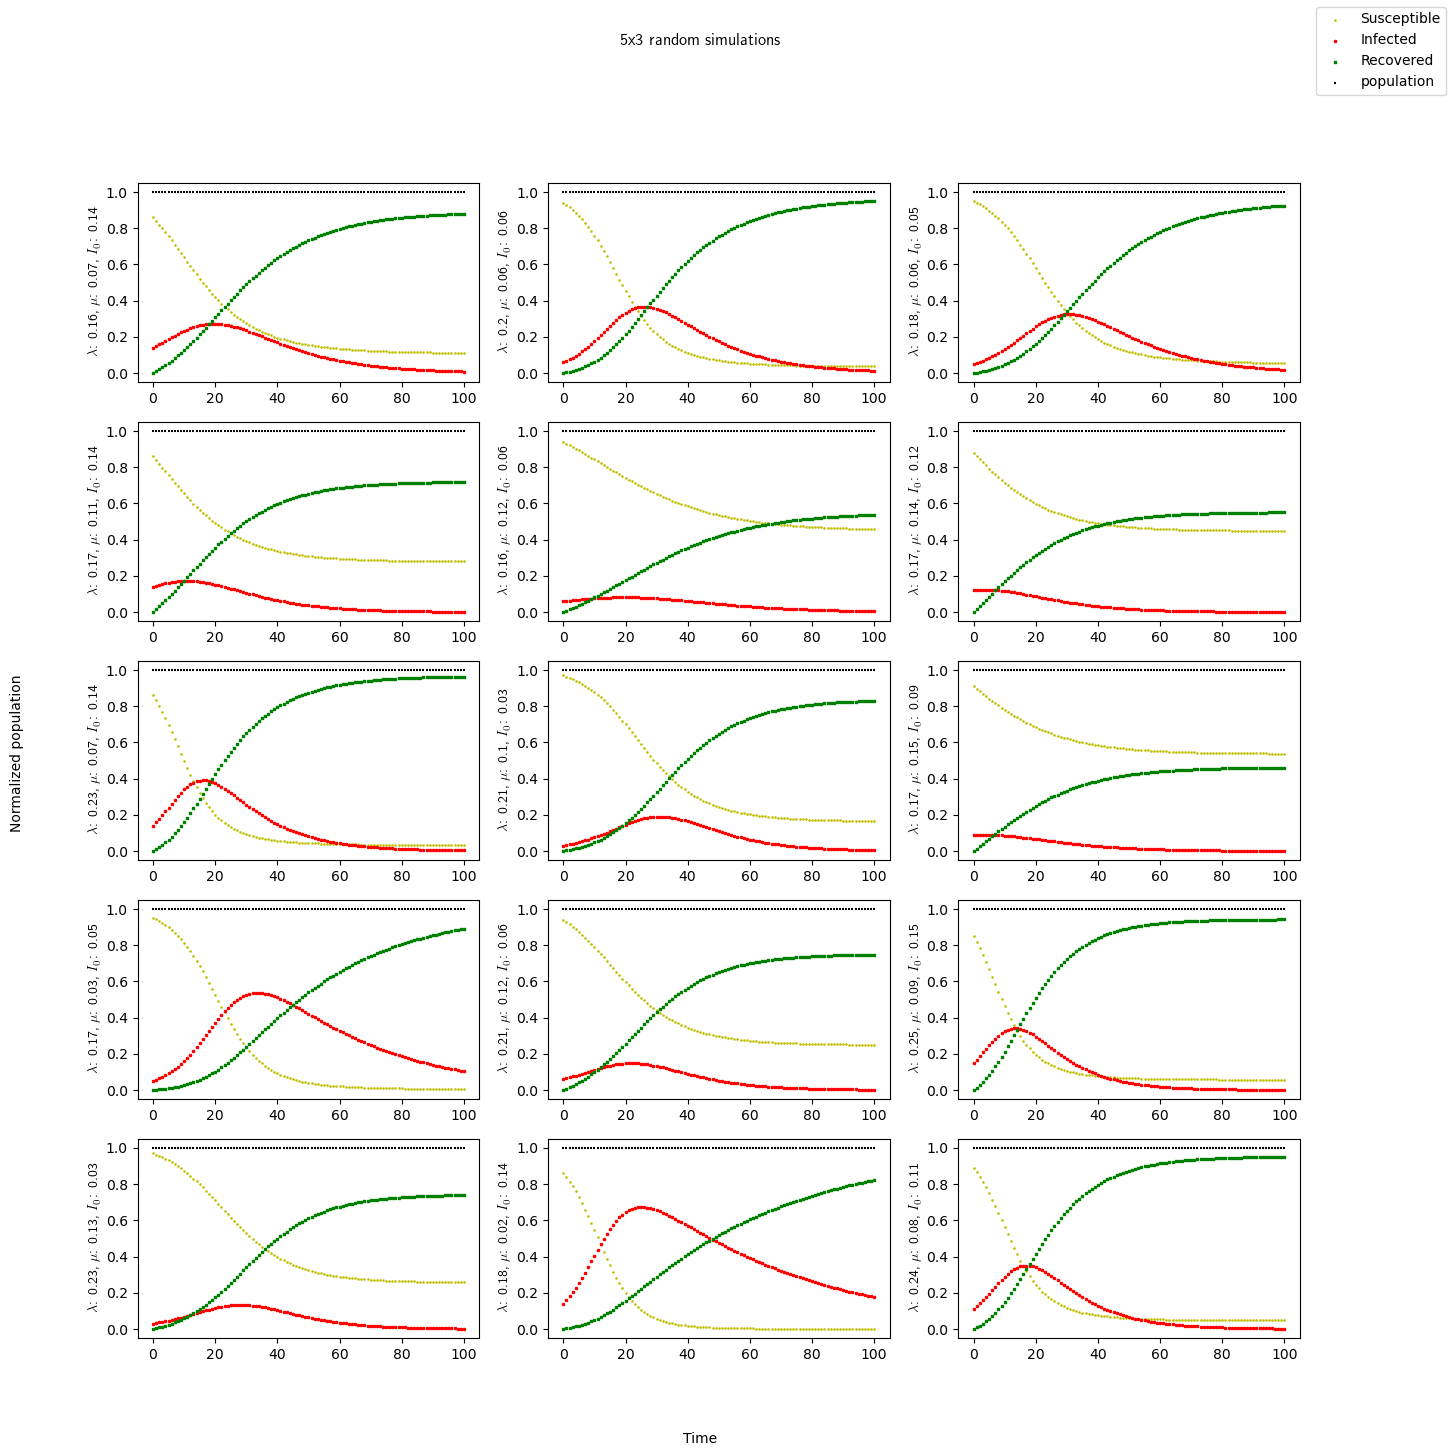

In [22]:
plot_many_random_simulations(n = 5, I_0_range =(0.01, 0.15), mu_range=(0.01, 0.15), lam_range=(0.15, 0.25))

The plots below show that the simulations with $\lambda \in [0.15, 0.25]$, $\mu \in [0.01, 0.15]$, $I_0 \in [0.05, 0.15]$ yield quite "interesting" results. Hence the distributions are
$p^{sim}(Y) = p^{sim}(\lambda) \cdotp p^{sim}(\mu) \cdotp p^{sim}(I_0) = U(0.15, 0.25) \cdotp U(0.01, 0.15) \cdotp U(0.05, 0.15)$

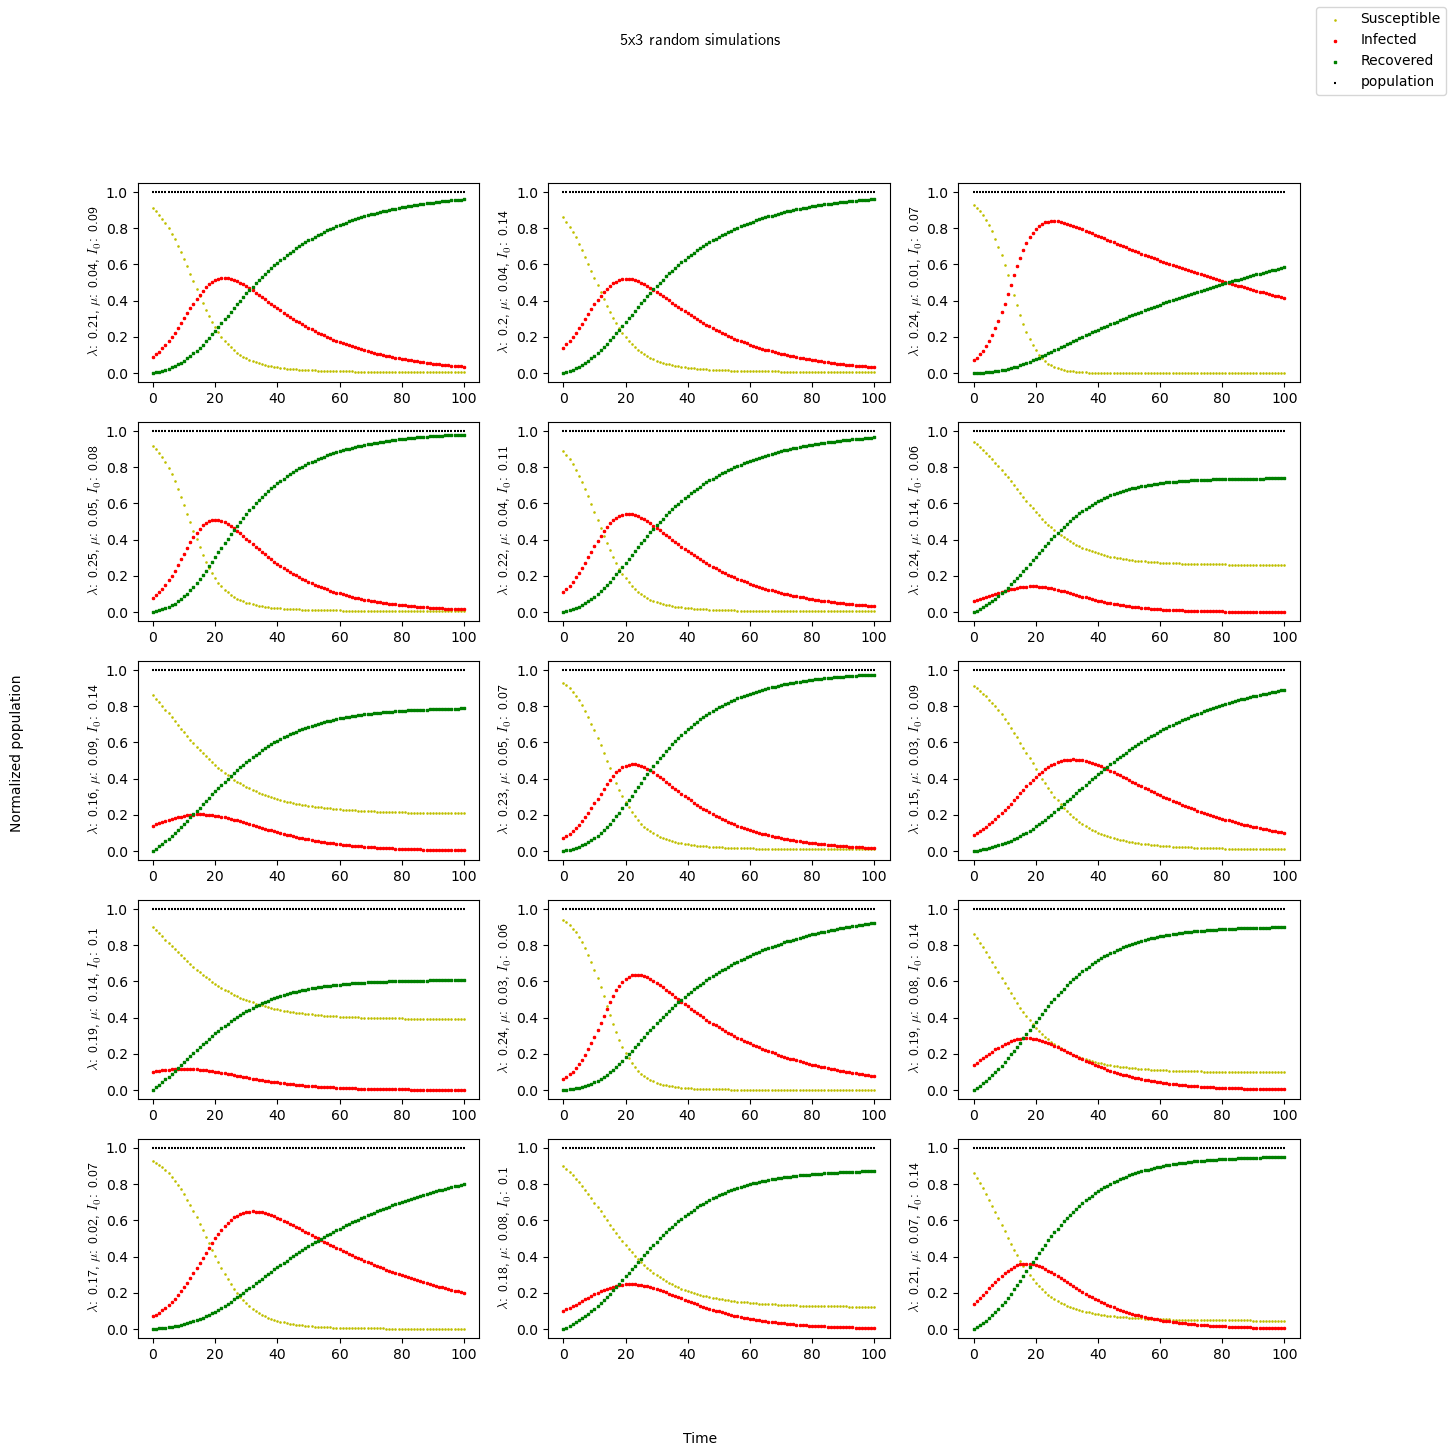

In [23]:
plot_many_random_simulations(n = 5, I_0_range =(0.05, 0.15), mu_range=(0.01, 0.15), lam_range=(0.15, 0.25))

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

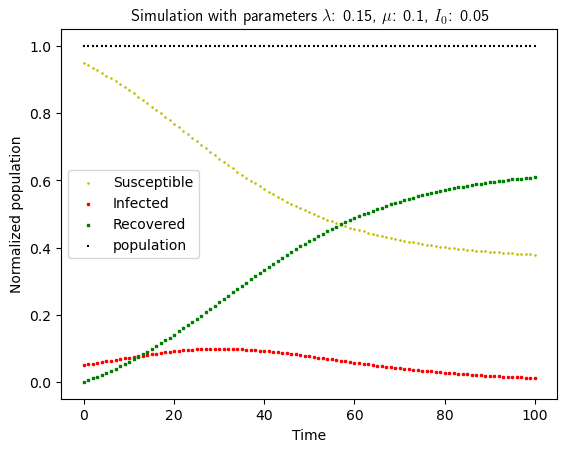

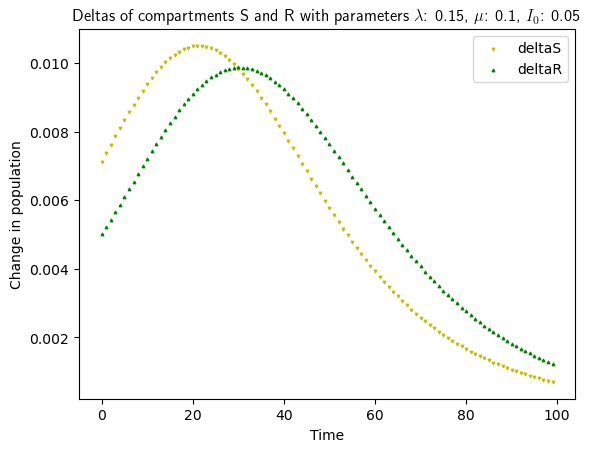

In [24]:
plot_simulation(0.15, 0.1, 0.05, 100)

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

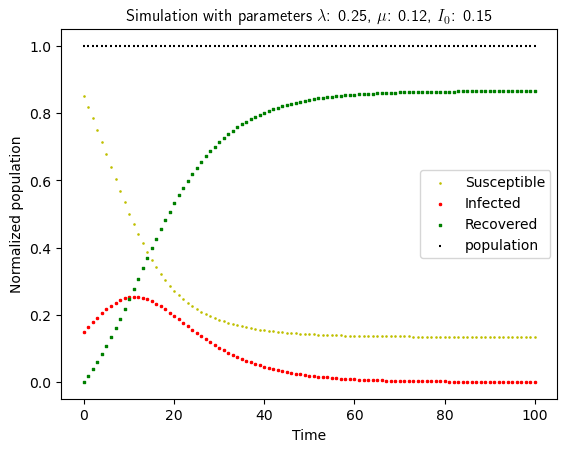

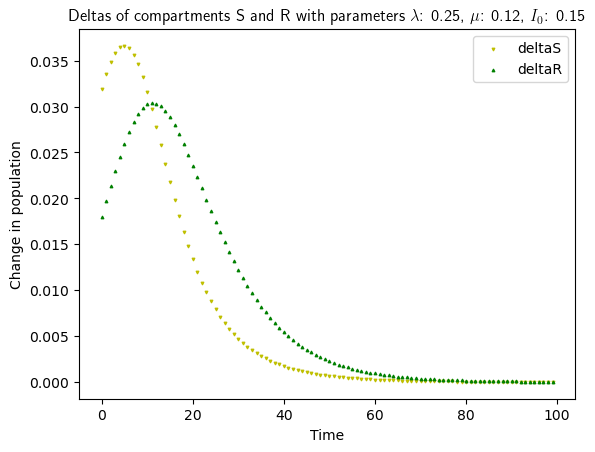

In [25]:
plot_simulation(0.25, 0.12, 0.15, 100)

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

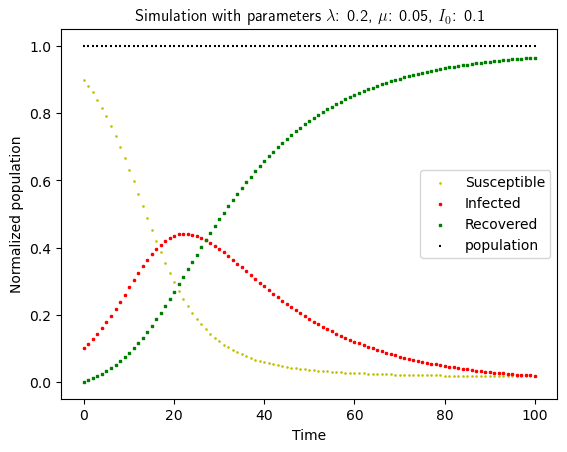

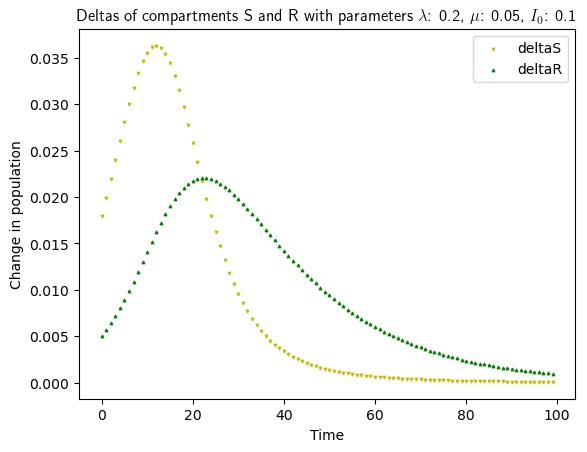

In [26]:
plot_simulation(0.2, 0.05, 0.1, 100)

3. Defne a feed-forward or convolutional network Φ that predicts parameters directly from observations, Yb = Φ(X). Train this network with the squared loss using a training set generated
by the simulation and prior distribution, and evaluate it by a simulated test set. Visualize
the accuracy as a function of hyperparameter choices (especially the sizes of the network and
training set) in suitable diagrams. Note that this network disregards potential uncertainty
and ambiguity of the inverse problem - it just returns a point estimate, i.e. a single vector of
plausible parameters Yb for every given X. For simplicity, the length of the sequence X (i.e.
the stopping time T) shall be constant for all training and testing runs

In [27]:
class ForwardPhi(nn.Module):
    def __init__(self, input_size, output_size, inner_chanel_size, kernel_size):
        super().__init__()
        self.network = nn.Sequential(nn.Conv1d(input_size, inner_chanel_size, kernel_size),
                                     nn.ReLU(),
                                     nn.Conv1d(inner_chanel_size, inner_chanel_size, kernel_size),
                                     nn.ReLU(),
                                     nn.Conv1d(inner_chanel_size, 1, kernel_size),
                                     nn.ReLU(),
                                     nn.LazyLinear(output_size)
        )
    
    def forward(self, X):
        return self.network(X)
    
    def validate(self, X_val, y_val):
        losses = []
        for i in range(len(X_val)):
            x, y = X_val[i], y_val[i]
            prediction = self.forward(x.T)[0]
            loss = nn.MSELoss()
            output = loss(y,prediction)
            losses.append(output.detach().numpy())
        return np.array(losses)
        
    
    def train_network(self, X_train, y_train):
        losses = []
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        for i in range(len(X_train)):
            x, y = X_train[i], y_train[i]
            prediction = self.forward(x.T)[0]
            loss = nn.MSELoss()
            output = loss(y, prediction)

            optimizer.zero_grad()
            output.backward()
            optimizer.step()
            losses.append(output.detach().numpy())
        return np.array(losses)
            
            

In [166]:
def generate_data_sets(training_size, set_size):
    assert set_size > training_size
    data_set = []
    Y = []
    for i in range(set_size):
        #y = [np.random.uniform(0.15, 0.25), np.random.uniform(0.01, 0.15), np.random.uniform(0.05, 0.15)]
        y = [np.random.normal(0.2, 0.025), np.random.normal(0.08, 0.025),  np.random.normal(0.1, 0.015)]
        sample = simulate_sir_simple(y[0], y[1], y[2], 100)
        deltas = np.array(generate_deltas(sample), dtype=np.float32)
        data_set.append(torch.tensor(deltas))
        Y.append(torch.tensor(y))
    x_train = data_set[:training_size]
    y_train = Y[:training_size]
    x_test = data_set[training_size:]
    y_test = Y[training_size:]
    return x_train, y_train, x_test, y_test 

# Part of task 2

In [29]:
def generate_noisy_data_sets(training_size, set_size):
    assert set_size > training_size
    data_set = []
    Y = []
    for i in range(set_size):
        L = np.random.choice([x for x in range(1, 41)])
        y = [np.random.uniform(0.15, 0.25), np.random.uniform(0.01, 0.15), np.random.uniform(0.05, 0.15), L, np.random.uniform(0.5, 1), np.random.uniform(0.05, 0.15)] 
        deltas =  np.array(simulate_sir_noisy(y[0], y[1], y[2], y[3], y[4], y[5], 100), dtype=np.float32)
        data_set.append(torch.tensor(deltas))
        Y.append(torch.tensor(y))
    x_train = data_set[:training_size]
    y_train = Y[:training_size]
    x_test = data_set[training_size:]
    y_test = Y[training_size:]
    return x_train, y_train, x_test, y_test 

# Task 1 again

In [30]:
def plot_parameters(input_size=2, output_size=3, inner_chanel_range = (1, 10), kernel_size_range= (1, 20), set_size_range = (1000, 13000), noisy=False):
    generator = lambda y, s: [x for x in range(*y, s)]
    inner_chanel_sizes = generator(inner_chanel_range, 1)
    kernel_sizes = generator(kernel_size_range, 1)
    set_sizes = generator(set_size_range, 3000)

    for set_size in set_sizes:
        if not noisy:
            x_train, y_train, x_test, y_test = generate_data_sets(int(np.floor(0.7 * set_size)), set_size)
        else:
            x_train, y_train, x_test, y_test = generate_noisy_data_sets(int(np.floor(0.7 * set_size)), set_size)
            
                
        mean_validation_errors = []
        final_train_errors = []
        fig, axs = plt.subplots(1, 2, figsize=(15, 15))
        for chanel_size in inner_chanel_sizes:
            final_train_error_column = []
            mean_validation_error_column = []
            for kernel_size in kernel_sizes:
                P = ForwardPhi(input_size, output_size, chanel_size, kernel_size)
                final_train_error_column.append(P.train_network(x_train, y_train)[-1])
                mean_validation_error_column.append(np.mean(P.validate(x_test, y_test)))
            mean_validation_error_column = np.array(mean_validation_error_column).T
            final_train_error_column = np.array(final_train_error_column).T
            mean_validation_errors.append(mean_validation_error_column)
            final_train_errors.append(final_train_error_column)
        

        mean_validation_errors = np.array(mean_validation_errors).T
        final_train_errors = np.array(final_train_errors).T
        axs[0].imshow(final_train_errors, extent=[*inner_chanel_range, *reversed(kernel_size_range)])
        axs[0].set_title(f"Final error in training, |ts|={set_size}")
        axs[1].set_title(f"Avg. validation error, |ts|={set_size}")
        axs[1].set_ylabel("Size of kernel")
        axs[1].set_xlabel("Size of inner chanels")
        axs[0].set_ylabel("Size of kernel")
        axs[0].set_xlabel("Size of inner chanels")
        
        im = axs[1].imshow(mean_validation_errors, extent=[*inner_chanel_range, *reversed(kernel_size_range)])
        fig.subplots_adjust(right=0.8)
        fig.colorbar(im, ax=axs, location="bottom")
        plt.figure()
            
        
                
                
    
    

KeyboardInterrupt: 

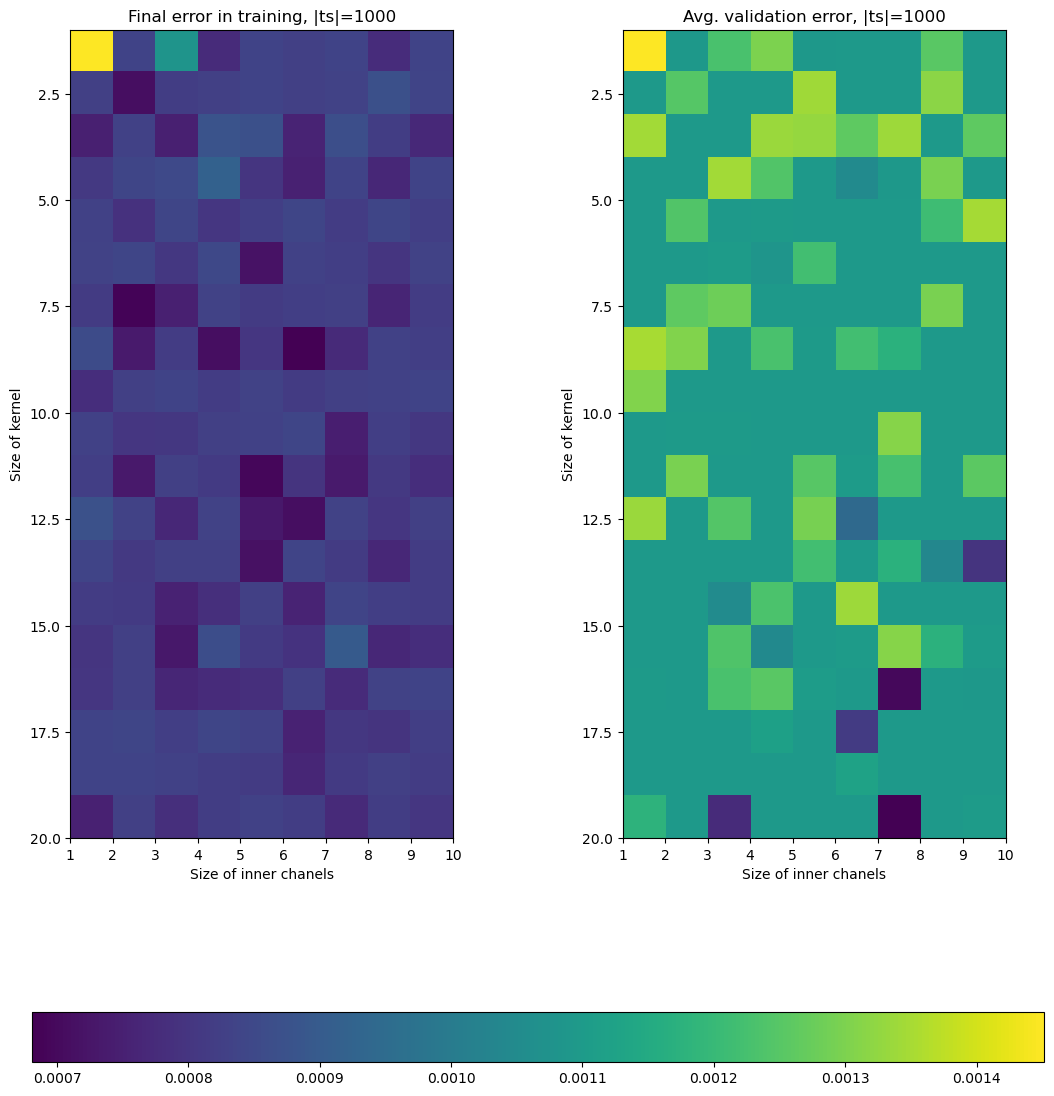

<Figure size 640x480 with 0 Axes>

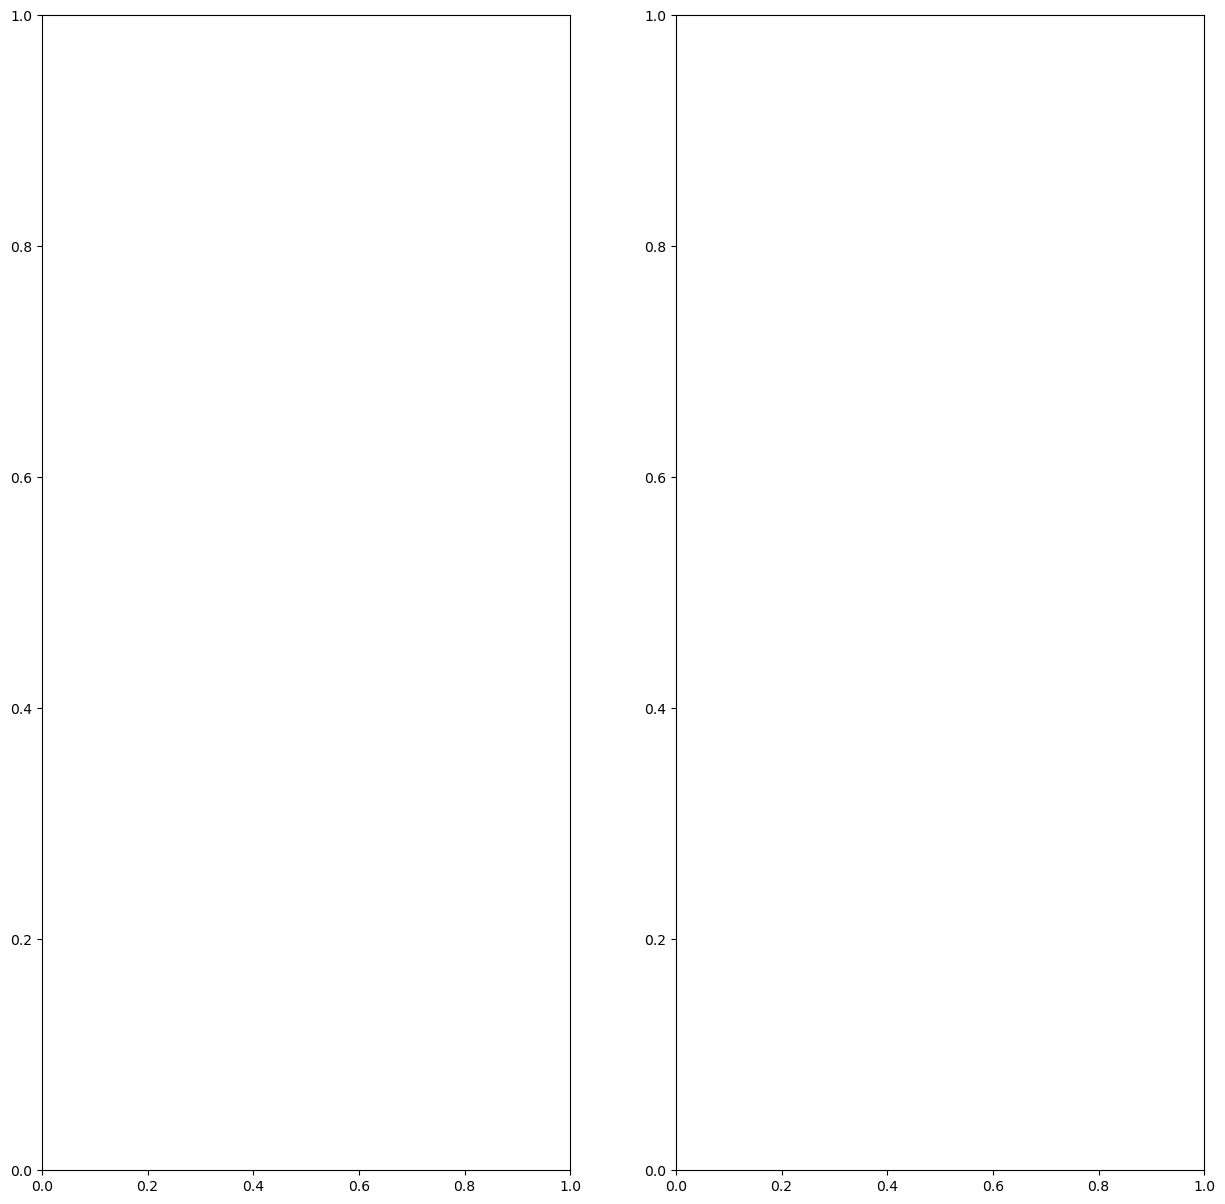

In [31]:
plot_parameters()

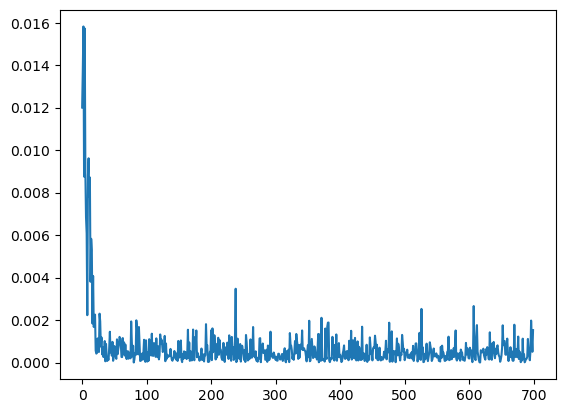

In [182]:
x_train, y_train, x_test, y_test = generate_data_sets(700, 1000)
P = ForwardPhi(2, 3, 6, 16)
losses = P.train_network(x_train, y_train)
plt.plot(losses)

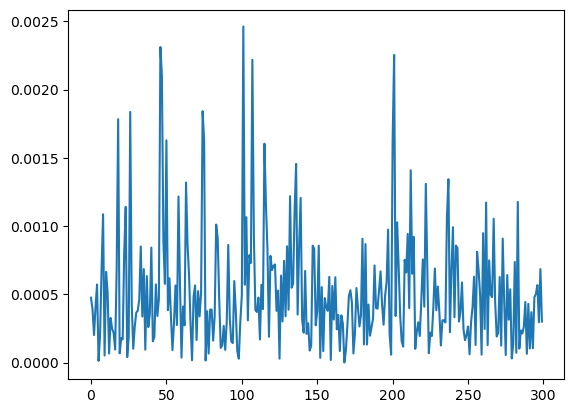

In [183]:
vals = P.validate(x_test, y_test)
plt.plot(vals)

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

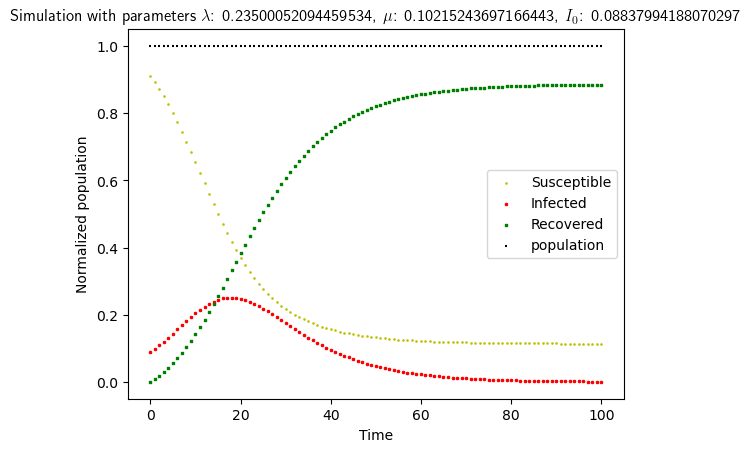

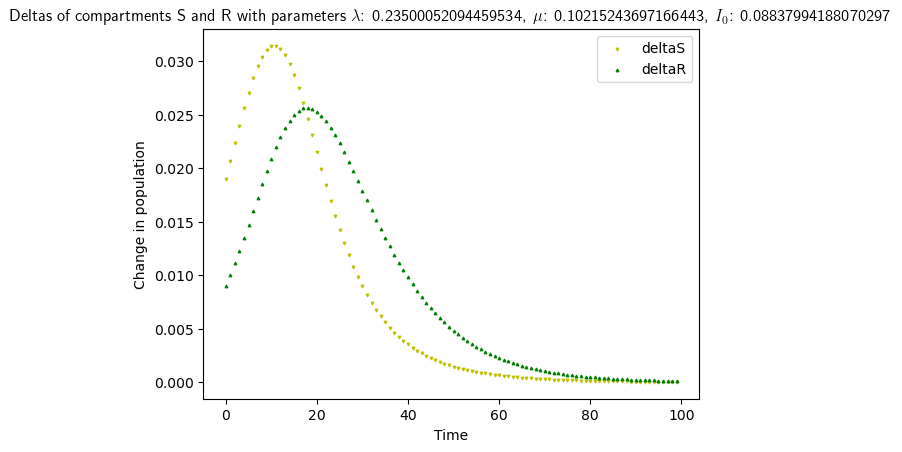

<Figure size 640x480 with 0 Axes>

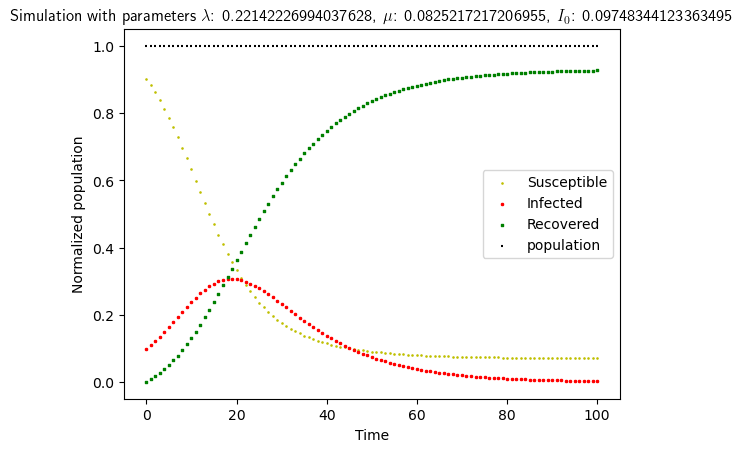

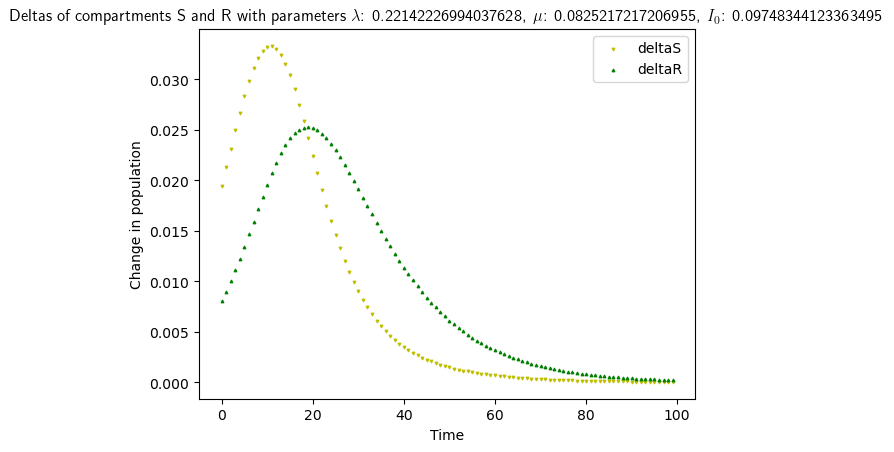

In [184]:
prediction = P.forward(x_test[15].T)[0].detach().numpy()
true = y_test[15]
plot_simulation(*true, 100)
plt.figure()
plot_simulation(*prediction, 100)

In [199]:
class RealNVP_condition(nn.Module):
    def __init__(self, nets, nett, mask, prior,input_size, inner_chanel_size, kernel_size, output_size):
        super(RealNVP_condition, self).__init__()

        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(mask))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(mask))])

        self.network = nn.Sequential(nn.Conv1d(input_size, inner_chanel_size, kernel_size),
                                    nn.ReLU(),
                                    nn.Conv1d(inner_chanel_size, inner_chanel_size, kernel_size),
                                    nn.ReLU(),
                                    nn.Conv1d(inner_chanel_size, 1, kernel_size),
                                    nn.ReLU(),
                                    nn.LazyLinear(output_size)
        )
    def forward(self, X):
        return self.network(X)

    def f(self, x, X):

        h=self.forward(X)#X batch_size*2*100  h batch_size*1*3 x batch_size*3
        h = torch.squeeze(h, dim=1)#
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in (range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](torch.cat([h,z_], dim=1)) * (1-self.mask[i])#z,h batch_size*3
            t = self.t[i](torch.cat([h,z_], dim=1)) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)

        return z, log_det_J

    def g(self, z, X):
        x = z

        h=self.forward(X)

        h = torch.squeeze(h, dim=1)
        for i in reversed(range(len(self.t))):
            x_ = x*self.mask[i]
            s = self.s[i](torch.cat([h,x_], dim=1))*(1 - self.mask[i])
            t = self.t[i](torch.cat([h,x_], dim=1))*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x


    def log_prob(self,x, X):
        z, logp = self.f(x, X)


        return self.prior.log_prob(z) + logp

    def sample(self, X,num):

        X_copies = X.unsqueeze(0).repeat(num, 1, 1)

        z = torch.randn(num, 3)

        x = self.g(z, X_copies)
        return x

def permutation_matrix(dim):
    matrix = np.eye(dim)
    np.random.shuffle(matrix)
    return torch.tensor(matrix, dtype=torch.float32)

#model
feature_size=1
dim=3
nets = lambda: nn.Sequential(nn.Linear(dim+feature_size, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, dim), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(dim+feature_size, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, dim))
masks = torch.from_numpy(np.array([[1,1, 0]] * 6).astype(np.float32))
for i in range(len(masks)):
  masks[i]=torch.matmul(permutation_matrix(dim),masks[i])
prior = distributions.MultivariateNormal(torch.zeros(dim), torch.eye(dim))
flow = RealNVP_condition(nets, nett, masks, prior,2,6,16, feature_size)

In [205]:
x_train, y_train, x_test, y_test = generate_data_sets(1000, 2000)

x_train = torch.stack(x_train, dim=0)
x_train = torch.transpose(x_train, 1, 2)
y_train = torch.stack(y_train,dim=0)

In [ ]:
import torch
from sklearn.datasets import make_moons
from torch import nn, optim
from torch.autograd import Variable
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


dataset = TensorDataset(x_train, y_train)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

optimizer = optim.Adam(flow.parameters(), lr=0.001)

#Train
num_epochs = 60
loss_list=[]

for epoch in tqdm(range(num_epochs)):
    for data in data_loader:
        x, y = data

        loss = -flow.log_prob(y.float(),x.float()).mean()

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    loss_list.append(loss.item())

 67%|██████▋   | 40/60 [01:22<00:41,  2.09s/it]

In [ ]:
plt.plot(loss_list)

In [ ]:
#generate lambda, mu, I for a fixed y: y_test[0]
sample_num=1000

y_fixed=y_test[0]
sample=flow.sample(x_test[0].T,sample_num)
lamda_hat=sample[:,0].detach().numpy()
mu_hat=sample[:,1].detach().numpy()
I_hat=sample[:,2].detach().numpy()



plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(lamda_hat, bins=20, edgecolor='black', alpha=0.7,density=True)
plt.title('$\hat{\lambda}$  GT value='+str(round(y_fixed[0].item(), 3)))

plt.subplot(1, 3, 2)
plt.hist(mu_hat, bins=20, edgecolor='black', alpha=0.7,density=True)
plt.title('$\hat{\mu}$  GT value='+str(round(y_fixed[1].item(), 3)))

plt.subplot(1, 3, 3)
plt.hist(I_hat, bins=20, edgecolor='black', alpha=0.7,density=True)
plt.title('$\hat{I}$  GT value='+str(round(y_fixed[2].item(), 3)))

plt.show()

In [ ]:
N=100
calibration=[]
para= 0

for i in range(len(x_test)):
    sample=flow.sample(x_test[i].T,N).detach().numpy()
    rank=0
    for j in range(N):
        if y_test[i][para].detach().numpy()>sample[j,para]:
            rank += 1

    calibration.append(rank)
plt.hist(calibration, bins=50,  edgecolor='black', density=True,alpha=0.7)

2 Noisy data
We now extend the basic SIR model with a noise model for the observations. Implement the new
function simulate_sir_noisy(lam, mu, I_0, L, rho, sigma_2, T), which outputs noisy sequences
X˜ = [...]
We assume that the noise is multiplicative Gaussian, i.e. follows the rule
∆S˜(t) = ∆S(t − L) · eS with eS ∼ N (ρ, σ2
)
∆R˜(t) = ∆R(t − L) · eR with eR ∼ N (ρ, σ2
)
The new parameters L ≥ 0, ρ ≤ 1, and σ
2
represent the reporting delay, underreporting fraction
and reporting error variance respectively. Visualize the difference between noise-free outcomes X
and noisy outcomes X˜ to extend good ranges for the new parameters and extend the prior p
sim(Y )
accordingly.
Extend your networks from task 1 to accomodate the additional parameters of the inverse problem.
Repeat the experiments and comment on your fndings.


In [86]:
def plot_noisy_data(n, L_range = (1, 40), rho_range=(0.001, 1), sigma_2_range= (0.01, 2), T=100):
    fig, axs = plt.subplots(n, 2, figsize=(15, 15))
    time_range = [t for t in range(T)]
    fig.suptitle("Deltas of compartments S and R with parameters")
    fig.text(0.5, 0.04, 'Time', ha='center')
    fig.text(0.04, 0.5, 'Change in population', va='center', rotation='vertical')
    for i in range(n):
        rho = round(np.random.uniform(*rho_range), 2)
        sigma_2 = round(np.random.uniform(*sigma_2_range), 2)
        L = np.random.choice([x for x in range(*L_range)])
        y = [np.random.uniform(0.15, 0.25), np.random.uniform(0.01, 0.15), np.random.uniform(0.05, 0.15)]
        time_range_shifted = [t for t in range(L, T)]
        results = simulate_sir_simple(*y, T)
        deltas = generate_deltas(results)
        noisy_deltas = generate_deltas(results, L, rho, sigma_2)
        

        
        axs[i, 0].set_ylabel(f" $\lambda$: {round(y[0], 2)}, $\mu$: {round(y[1], 2)}, $I_0$: {round(y[2], 2)}", usetex = True)
        axs[i, 0].scatter(time_range, deltas[:, 0], marker="v", s=3, color="y", label="deltaS")
        axs[i, 0].scatter(time_range, deltas[:, 1], marker="^", s=3, color="g", label="deltaR")
        
        axs[i, 1].set_ylabel(f"L: {L}, $p$: {rho}, $\sigma^2$: {sigma_2}", usetex = True)
        axs[i, 1].scatter(time_range, noisy_deltas[:, 0], marker="v", s=3, color="y", label="deltaS")
        axs[i, 1].scatter(time_range, noisy_deltas[:, 1], marker="^", s=3, color="g", label="deltaR")


        axs[i, 0].legend()
        axs[i, 1].legend()

In the plots below, it can be observed that not much happens beyond t=60, hence L should be at most 40. Also for to large $\sigma^2$, the curves get too noisy. Hence $\sigma^2$ < 0.15 should be sufficient. For $\rho$, the assumption that at least 50% of the cases get actually registered should be suitable, even tho it is arbitrary.

In [ ]:
plot_noisy_data(5)

The results below look valod, yielding the distributions $p^{sim}(Y) = p^{sim}(\lambda) \cdotp p^{sim}(\mu) \cdotp p^{sim}(I_0)p^{sim}(L)p^{sim}(\rho)p^{sim}(\sigma^2)    = U(0.15, 0.25) \cdotp U(0.01, 0.15) \cdotp U(0.05, 0.15)\cdotp U(1, 40)\cdotp U(0.5, 1)\cdotp U(0.05, 0.1)$

In [ ]:
plot_noisy_data(5, L_range=(0, 40), sigma_2_range=(0.05, 0.15), rho_range=(0.5, 1))

In [87]:
def simulate_sir_noisy(lam, mu, I_0, L, rho, sigma_2, T):
    results = simulate_sir_simple(lam, mu, I_0, T)
    return generate_deltas(results, L = L, rho=rho, sigma_2=sigma_2)

In [ ]:
x_train, y_train, x_test, y_test = generate_noisy_data_sets(700, 1000)
P = ForwardPhi(2, 6, 4, 14)
losses = P.train_network(x_train, y_train)
plt.plot(losses)

In [ ]:
vals = P.validate(x_test, y_test)
plt.plot(vals)

In [ ]:
plt.plot(x_train[0])

In [ ]:
P = 

In [ ]:
plot_parameters(input_size=2, output_size=6, noisy=True)

In [ ]:
prediction = P.forward(x_test[15].T)[0].detach().numpy()
true = y_test[15]
plot_simulation(*true[:3], 100)
plt.figure()
plot_simulation(*prediction[:3], 100)

In [88]:

#model
feature_size=6
dim=3
nets = lambda: nn.Sequential(nn.Linear(dim+feature_size, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, dim), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(dim+feature_size, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, dim))
masks = torch.from_numpy(np.array([[1,1, 0]] * 6).astype(np.float32))
for i in range(len(masks)):
  masks[i]=torch.matmul(permutation_matrix(dim),masks[i])
prior = distributions.MultivariateNormal(torch.zeros(dim), torch.eye(dim))
flow = RealNVP_condition(nets, nett, masks, prior,2,6,16, feature_size)

In [89]:
x_train, y_train, x_test, y_test = generate_noisy_data_sets(1400, 2000)

x_train = torch.stack(x_train, dim=0)
x_train = torch.transpose(x_train, 1, 2)
y_train = torch.stack(y_train,dim=0)